In [62]:
import pandas as pd

data = 'cifar'

df = pd.read_csv(f'search_{data}_cluster.csv')

if data == 'cifar':
    df = df[~df['predictor'].isin(['gcn', 'seminas', 'nao'])]
else:
    df = df[df['predictor'] != 'seminas']
    
df2 = pd.read_csv(f'search_{data}_ui.csv')
df_rs = pd.read_csv(f'search_{data}_rs.csv')
df_rs = df_rs[df_rs['predictor'] == 'xgb'].copy()
df_rs['predictor'] = 'random_search'
df = pd.concat([df, df2, df_rs]).reset_index()

In [63]:
# get mean proxy time per net (from nb suite zero jsons)
def get_prox_time(data):
    proxy_time = {p: 0.0 for p in data['(3, 3, 3, 3, 3, 3)'].keys() if p != 'id' and p != 'val_accuracy'}
    for entry in data.values():
        for p in proxy_time.keys():
            proxy_time[p] += entry[p]['time']
    return {p: val / len(data) for p, val in proxy_time.items()}

In [64]:
mean_feature_seconds = 27.3 / 9445  # total 27.3 seconds per 9445 nets
if data == 'cifar':
    mean_proxy_seconds = 12.49954779239535
elif data == 'img':
    mean_proxy_seconds = 11.972471429167896
else:
    raise ValueError("Invalid bench")

In [65]:
n_epochs = 200  # the metric of train_time is epochseconds
n_sampled = 200

df['val_err'] = 100.0 - df['valid_acc']
df['total_time'] = df['runtime'] + df['train_time'] * n_epochs
df.loc[df['predictor'].str.contains('graph'), 'total_time'] += + n_sampled * mean_proxy_seconds + n_sampled * mean_feature_seconds
df.columns

Index(['index', 'benchmark', 'predictor', 'seed', 'dataset', 'valid_acc_step',
       'runtime_step', 'train_time_step', 'step', 'valid_acc', 'runtime',
       'train_time', 'val_err', 'total_time'],
      dtype='object')

In [66]:
df = df[df['seed'] < 50]
df.groupby(['benchmark', 'predictor']).count()['seed']

benchmark    predictor                
nasbench201  bananas                      25000
             bayes_lin_reg                25000
             bohamiann                    25000
             bonas                        25000
             dngo                         25000
             gcn                          25000
             gp                           25000
             graph_features               25000
             graph_features_xgb           25000
             graph_features_xgb_params    25000
             lgb                          25000
             mlp                          25000
             nao                          25000
             ngb                          25000
             random_search                25000
             rf                           25000
             seminas                      25000
             sparse_gp                    25000
             var_sparse_gp                25000
             xgb                          25000
N

In [67]:
run_count = 50 * 500

# check if nothing missing
assert (df.groupby(['benchmark', 'predictor']).count()['seed'] == run_count).all()
assert len(df['benchmark'].unique()) == 1 and len(df['dataset'].unique()) == 1

In [68]:
import os

if not os.path.exists('results'):
    os.mkdir('results')

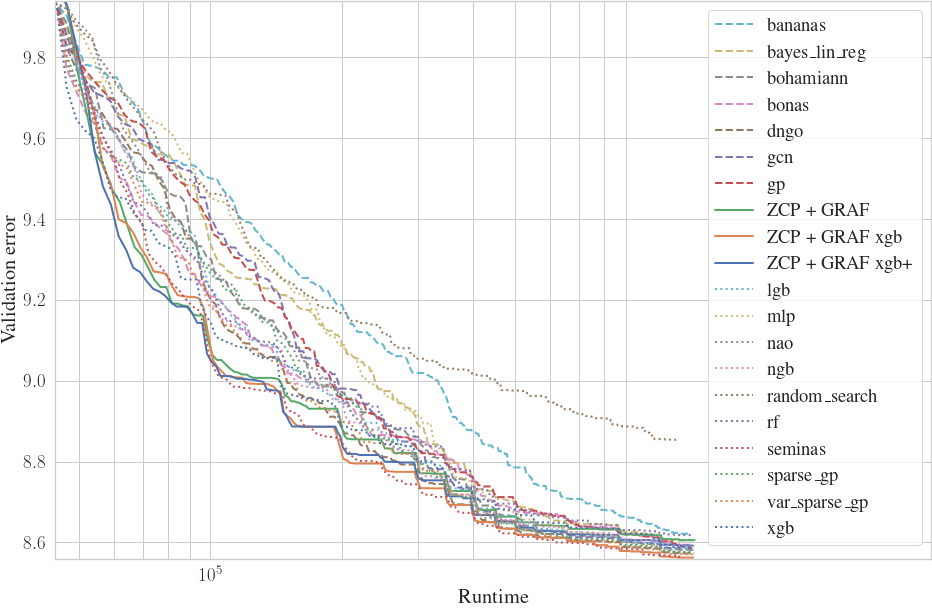

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

bench = df.iloc[0]['benchmark']
dataset = df.iloc[0]['dataset']
metric = 'valid_acc'



rc = {'text.usetex': True, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015}#, 'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8}
#plt.rcParams.update(rc)

sns.set(rc=rc, font_scale=1.7, style='whitegrid', palette=sns.color_palette()[::-1])

plot_df = df
#plot_df = df[(df['predictor'] == 'graph_features_xgb_params') | ~df['predictor'].str.contains('bananas')]
#plot_df = df[(df['predictor'] == 'bananas') | df['predictor'].str.contains('graph')]
#plot_df = df[(df['predictor'] != 'bananas')]


plt.figure(figsize=(13,8.5))
preds = df['predictor'].unique()

for i, p in enumerate(sorted(preds)):
    name = p.replace('graph_features_', 'ZCP + GRAF ')
    name = name.replace('graph_features', 'ZCP + GRAF')
    name = name.replace('xgb', ' xgb')
    name = name.replace('xgb_params', ' xgb+')
    
    time = 'total_time'
    col = 'red' if 'graph' in p else 'blue'
    what = 'val_err'
    style = 'dashed' if i < len(preds) // 2 else 'dotted'
    style = 'solid' if 'graph' in p else style
    
    vals = df[df['predictor'] == p][['step', what, time]].groupby('step').mean().sort_index()
    std = df[df['predictor'] == p][['step', what]].groupby('step').std().sort_index()[what]
    plt.plot(vals[time], vals[what], linewidth=2, label=name, linestyle=style)#, color=col)
    #plt.fill_between(vals[time], vals['valid_acc'] - std, vals['valid_acc'] + std, color=col, alpha=0.05)

#sns.lineplot(data=plot_df, x='total_time_grouped', y=metric, hue='predictor', errorbar='ci')
#plt.title(f"search - {bench} {dataset} {time}")
plt.xscale('log')

if dataset == 'cifar10':
    if time == 'total_time':
        plt.xlim(4.4e4, 4.5e6)#1e6)#2e6)
        plt.xticks([i * 1e4 for i in range(5, 10)] + [i * 1e5 for i in range(1, 10)])# + [i * 1e6 for i in range(1, 3)])
    elif time == 'train_time':
        plt.xlim(2e2, 1e4)
    plt.ylim(8.56, 9.94)  
elif dataset == 'ImageNet16-120':
    plt.xlim(2.72e5, 3e7)#7e6)
    plt.xticks([i * 1e5 for i in range(3, 10)] + [i * 1e6 for i in range(1, 8)])# + [i * 1e7 for i in range(1, 2)])
    plt.ylim(52.8, 55.18)
    
    
plt.legend(loc='upper right')

plt.xlabel('Runtime')
plt.ylabel('Validation error')


#plt.tight_layout()


plt.savefig(f'results/{bench}_{dataset}_{time}.pdf')
plt.show()

In [249]:
df[df['predictor'] == 'xgb'][['step', 'valid_acc', 'total_time']].groupby('step').mean().sort_index()


,valid_acc,total_time
step,,
0,87.0274,1.869335e+03
1,88.2676,3.876306e+03
2,88.7840,5.971825e+03
3,89.1308,8.080234e+03
4,89.4176,1.025655e+04
...,...,...
495,91.4110,1.273965e+06
496,91.4110,1.276551e+06
497,91.4110,1.279136e+06


In [ ]:
df[df['train_size'] == 500][['predictor', 'fit_time', 'train_time']].groupby('predictor').mean()